In [1]:
# Import necessary libraries
from pathlib import Path
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import shutil, re, numpy as np
from kagglehub import dataset_download

RAW_DIR = Path("data/raw"); RAW_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("reports/eda/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)


c:\Users\LENOVO\Desktop\Project\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### 1 Download dataset (runs once)

expected = [RAW_DIR / name for name in [
    "events.csv", "category_tree.csv",
    "item_properties_part1.csv", "item_properties_part2.csv",
]]

if not all(f.exists() for f in expected):
    print("Downloading Retail Rocket CSVs…")
    dl = Path(dataset_download("retailrocket/ecommerce-dataset"))
    for csv in dl.glob("*.csv"):
        shutil.copy2(csv, RAW_DIR / csv.name)
    print("✔️ Done →", RAW_DIR)
else:
    print("CSVs already present →", RAW_DIR)


CSVs already present → data\raw


In [4]:
### 2 Load `events.csv` with memory‑friendly dtypes

dtypes = {
    "event_type": "category",
    "categoryid": "Int64",
    "item_id": "Int32",
    "visitorid": "Int32",
}

events = pd.read_csv(RAW_DIR / "events.csv", dtype=dtypes)
# Convert Unix‑ms → datetime
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
print(f"Events: {len(events):,} rows | RAM {events.memory_usage(deep=True).sum()/1e6:.1f} MB")

# Determine the actual category column name
CAT_COL = "categoryid" if "categoryid" in events.columns else "category_id"

Events: 2,756,101 rows | RAM 248.6 MB


Saved → reports\eda\figures\daily_volume.png


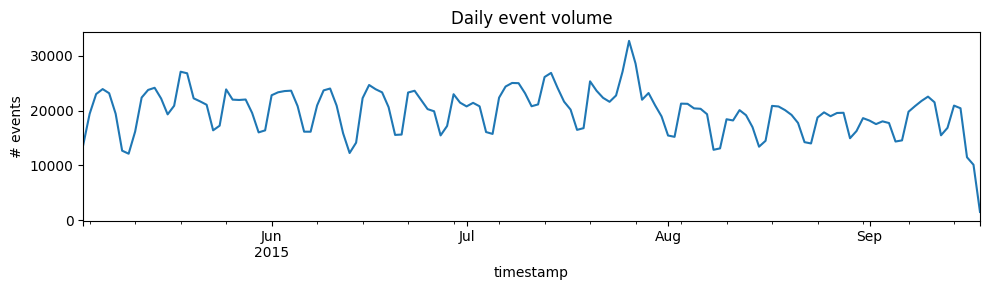

In [6]:
### 3 Daily event volume (time series)

# Plot daily event volume
fig_path = FIG_DIR / "daily_volume.png"
fig, ax = plt.subplots(figsize=(10, 3))
(events.set_index("timestamp").resample("D").size()
       .plot(ax=ax, title="Daily event volume"))
ax.set_ylabel("# events")
fig.tight_layout(); fig.savefig(fig_path, dpi=120)
print("Saved →", fig_path)

Saved → reports\eda\figures\hour_weekday_heatmap.png


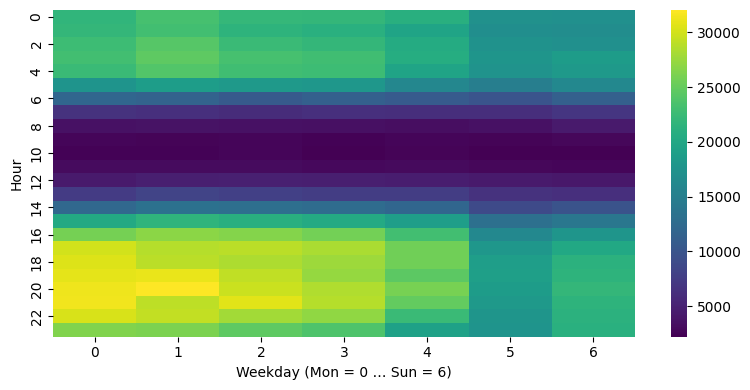

In [7]:
### 4 Hour × Weekday heatmap

# Create a heatmap of hourly event counts by weekday
# (0=Monday, 6=Sunday)
heat = (events.assign(hour=events["timestamp"].dt.hour,
                     wday=events["timestamp"].dt.dayofweek)
              .pivot_table(index="hour", columns="wday", values="visitorid",
                           aggfunc="count", fill_value=0)
              .astype(float))
fig2_path = FIG_DIR / "hour_weekday_heatmap.png"
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(heat, cmap="viridis", ax=ax)
ax.set_xlabel("Weekday (Mon = 0 … Sun = 6)"); ax.set_ylabel("Hour")
fig.tight_layout(); fig.savefig(fig2_path, dpi=120)
print("Saved →", fig2_path)


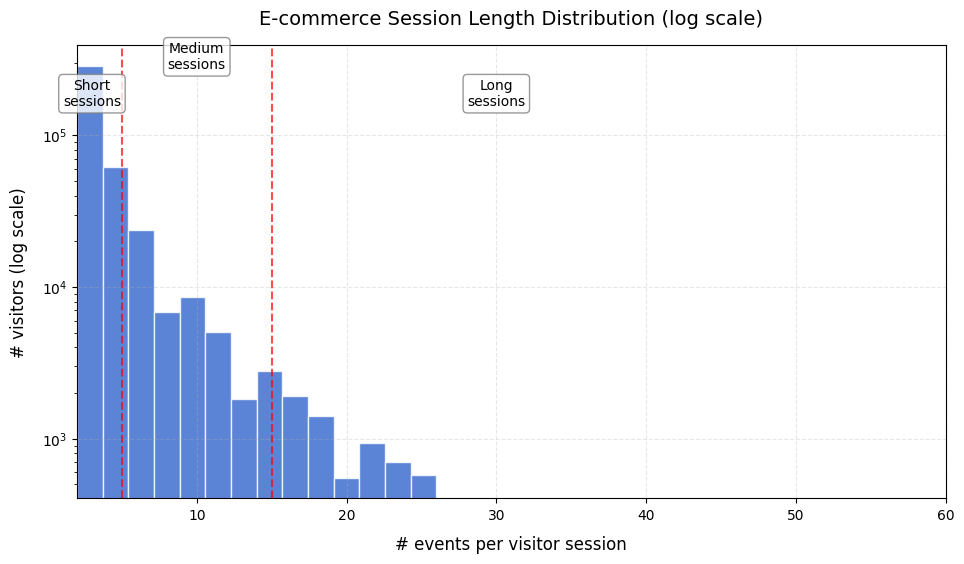

Saved → reports\eda\figures\session_length_hist.png
Median session length: 2.0 events
Mean session length: 4.3 events
95th percentile: 10.0 events


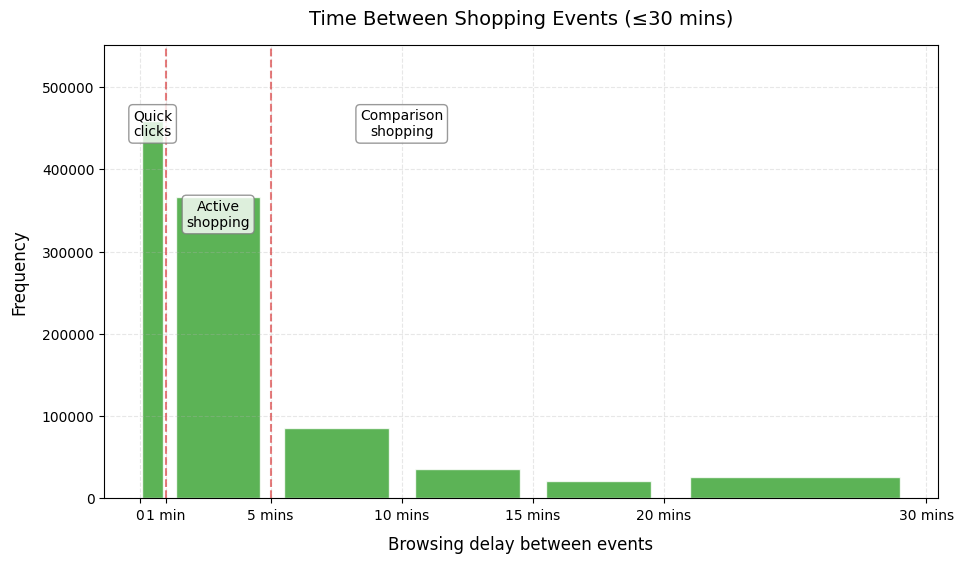

Saved → reports\eda\figures\inter_event_time_hist.png
Median time between events: 136.4 seconds (2.3 minutes)
% events within 1 minute: 34.0%


In [8]:
### 5. Visitor behavior analysis - Retail Rocket e-commerce patterns

# 5.1 Session-length distribution (e-commerce browsing patterns)
if 'visitorid' in events.columns:
    # Calculate events per visitor (session length)
    sess_counts = events.groupby('visitorid').size()
    
    # Filter for meaningful sessions (>1 event)
    sess_counts = sess_counts[sess_counts > 1]
    
    # Create better bins to avoid square box appearance
    max_display = np.percentile(sess_counts, 99)  # Use 99th percentile for better display
    bins = np.linspace(2, max_display, 15)  # Fewer, more spread out bins
    
    fig_path = FIG_DIR / 'session_length_hist.png'
    
    # Create figure with more explicit spacing
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use custom bins and log=True for better visualization
    ax.hist(sess_counts, bins=bins, color='#3366cc', alpha=0.8, 
             edgecolor='white', log=True)
    
    # Mark typical e-commerce session ranges
    ax.axvline(x=5, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.axvline(x=15, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Add annotations at different heights to avoid overlap
    y_height = ax.get_ylim()[1]
    
    # Clear text backgrounds
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    
    # Position text at different heights to avoid overlap
    ax.text(3, y_height*0.4, 'Short\nsessions', ha='center', fontsize=10, bbox=bbox_props)
    ax.text(10, y_height*0.7, 'Medium\nsessions', ha='center', fontsize=10, bbox=bbox_props)
    ax.text(30, y_height*0.4, 'Long\nsessions', ha='center', fontsize=10, bbox=bbox_props)
    
    ax.set_title('E-commerce Session Length Distribution (log scale)', fontsize=14, pad=15)
    ax.set_xlabel('# events per visitor session', fontsize=12, labelpad=10)
    ax.set_ylabel('# visitors (log scale)', fontsize=12, labelpad=10)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Set x-limit to focus on meaningful data
    ax.set_xlim(2, max(60, max_display))
    
    # Apply tight layout BEFORE saving
    fig.tight_layout(pad=2.0)
    fig.savefig(fig_path, dpi=150)
    plt.show()
    plt.close(fig)
    print('Saved →', fig_path)
    
    # Also print some key statistics
    print(f"Median session length: {sess_counts.median():.1f} events")
    print(f"Mean session length: {sess_counts.mean():.1f} events")
    print(f"95th percentile: {np.percentile(sess_counts, 95):.1f} events")


# 5.2 Inter-event time distribution (shopper engagement patterns)
if 'visitorid' in events.columns and 'timestamp' in events.columns:
    diffs = events.sort_values(['visitorid','timestamp']).groupby('visitorid')['timestamp'].diff().dropna().dt.total_seconds()
    
    # Focus on most relevant e-commerce time intervals
    diffs_filtered = diffs[diffs <= 1800]  # 30 minutes in seconds
    
    fig_path = FIG_DIR / 'inter_event_time_hist.png'
    
    # Create a figure with explicit axes for better control
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use custom bins for more meaningful e-commerce intervals
    custom_bins = [0, 60, 300, 600, 900, 1200, 1800]
    n, bins, patches = ax.hist(diffs_filtered, bins=custom_bins, color='#33a02c', 
                              alpha=0.8, edgecolor='white', rwidth=0.8)
    
    # Force y-axis to start from 0 and make bars taller
    highest_count = max(n)
    ax.set_ylim(0, highest_count * 1.2)  # Add 20% space at top
    
    ax.set_title('Time Between Shopping Events (≤30 mins)', fontsize=14, pad=15)
    ax.set_xlabel('Browsing delay between events', fontsize=12, labelpad=10)
    ax.set_ylabel('Frequency', fontsize=12, labelpad=10)
    
    # More meaningful time markers with increased spacing
    ax.set_xticks(custom_bins)
    ax.set_xticklabels(['0', '1 min', '5 mins', '10 mins', '15 mins', '20 mins', '30 mins'], 
                      fontsize=10, rotation=0)
    
    # Add vertical lines for major thresholds
    ax.axvline(x=60, color='#d62728', linestyle='--', alpha=0.6, linewidth=1.5)
    ax.axvline(x=300, color='#d62728', linestyle='--', alpha=0.6, linewidth=1.5)
    
    # Clear text with white background
    bbox_props = dict(boxstyle="round", fc="white", ec="gray", alpha=0.8)
    
    # Get y limits for better text placement
    y_height = ax.get_ylim()[1]
    
    # Position annotations at different heights to avoid overlap
    ax.text(30, y_height*0.8, 'Quick\nclicks', ha='center', fontsize=10, bbox=bbox_props)
    ax.text(180, y_height*0.6, 'Active\nshopping', ha='center', fontsize=10, bbox=bbox_props)
    ax.text(600, y_height*0.8, 'Comparison\nshopping', ha='center', fontsize=10, bbox=bbox_props)
    
    ax.grid(alpha=0.3, linestyle='--')
    
    # Apply tight layout BEFORE saving
    fig.tight_layout(pad=2.0)
    fig.savefig(fig_path, dpi=150)
    plt.show()
    plt.close(fig)
    print('Saved →', fig_path)
    
    # Also print key statistics about browsing behavior
    print(f"Median time between events: {diffs.median():.1f} seconds ({diffs.median()/60:.1f} minutes)")
    print(f"% events within 1 minute: {(diffs <= 60).mean()*100:.1f}%")
else:
    print("⚠️ Missing columns; skipping inter-event time distribution.")

In [9]:
summary_lines = []
summary_lines.append(f"# EDA Summary")
summary_lines.append(f"* Events: **{len(events):,}** rows")
summary_lines.append(f"* Date range: **{events['timestamp'].min().date()} -> {events['timestamp'].max().date()}**")  # Changed → to ->
summary_lines.append(f"* Unique visitors: **{events['visitorid'].nunique():,}**")


if 'itemid' in events.columns:
    summary_lines.append(f"* Unique items: **{events['itemid'].nunique():,}**")

summary_lines.append("\nFigures generated:")
# List generated figure files dynamically
fig_files = [p.name for p in FIG_DIR.glob("*.png")]
for idx, fname in enumerate(fig_files, 1):
    summary_lines.append(f"{idx}. `{fname}` - " + {
        'daily_volume.png': 'Event volume across the dataset time period',
        'hour_weekday_heatmap.png': 'Activity patterns by hour and weekday',
        'session_length_hist.png': 'Distribution of visitor session lengths',
        'inter_event_time_hist.png': 'Time intervals between shopping events'
    }.get(fname, 'Analysis chart'))

summary_md = "\n".join(summary_lines)
md_path = FIG_DIR.parent / "eda_summary.md"
md_path.write_text(summary_md.strip(), encoding="utf-8")  # Add UTF-8 encoding
print("Summary →", md_path)
print(summary_lines)

Summary → reports\eda\eda_summary.md
['# EDA Summary', '* Events: **2,756,101** rows', '* Date range: **2015-05-03 -> 2015-09-18**', '* Unique visitors: **1,407,580**', '* Unique items: **235,061**', '\nFigures generated:', '1. `daily_volume.png` - Event volume across the dataset time period', '2. `hour_weekday_heatmap.png` - Activity patterns by hour and weekday', '3. `inter_event_time_hist.png` - Time intervals between shopping events', '4. `session_length_hist.png` - Distribution of visitor session lengths']
